In [13]:
#Tasks to pass this assignment with a grade 3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

In [14]:
#1. Read the csv/xl file into pandas data-frame
df = pd.read_excel("C:/Programming/IAI-eMaintenance-Assignment-2/train delays-1.xlsx")

For task 2 I've added the features Punctual: if delay is under 5min, Weekday, IsWeekend, DelayInterval: sort of the amount of delay into 5 intervalls represented as numbers, Route/Train/Place-Counter. These were both added in the beginning but also when they were needed during the later part of the assignment.

In [15]:
#2. Feature engineering – add additional features to the dataset if required, explain !

#column for punctual/delayed <5min train is punctual (1) otherwise (0)
df["Punctual"] = (df["registered delay"] < 5).astype(int)

#function for grade 5 to represent delays as discrete variables
def delay_into_discrete(delay):
    if delay <= 5:
        return 0 
    elif delay <= 15:
        return 1 
    elif delay <= 30:
        return 2 
    elif delay <= 60:
        return 3
    else: return 4

df["DelayInterval"] = df["registered delay"].apply(delay_into_discrete)

#change to datetime for dt to work
df["Date"] = pd.to_datetime(df["Date"])
# new column for day of the week
df["WeekDay"] = df["Date"].dt.dayofweek
df["IsWeekend"] = df["WeekDay"] >= 5

# numerical days to categorical for readability
#day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
#df['WeekDay'] = df['WeekDay'].map({i: day_names[i] for i in range(7)})
#columns for amount of delays for specific route, tågnr and place
df["RouteDelayCount"] = df.groupby("Route")["registered delay"].transform("count")
df["TrainDelayCount"] = df.groupby("Tågnr")["registered delay"].transform("count")
df["PlaceDelayCount"] = df.groupby("Place")["registered delay"].transform("count")

df.to_csv("outputBeforeGeopy.csv", index=False)


In [ ]:
#3. Data Pre-processing –Remove unnecessary data, explain!

#first column was empty so it got removed.
df.drop(columns=["Unnamed: 0", "Operator", "Train ID", "Train mission", "Reason code", "Reason code - level 1", "Reason code Level 2", "Reason code Level 3", "Train number", "Year"], axis=1, inplace=True)

#remove all rows where the route was not specified
df = df[df["Route"] != "-"]

#save to check the data
df.to_csv("outputBeforeGeopy.csv", index=False)

In [17]:
#4. Data visualisation – Fetching latitude and longitude of the places mentioned in the dataset

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point
from tqdm import tqdm
tqdm.pandas()

geolocator = Nominatim(user_agent="train_delay", timeout=10)
geocode = RateLimiter(lambda query: geolocator.geocode(query, country_codes="SE"), min_delay_seconds=1)

#new dataframe with all places once
place_coords_df = pd.DataFrame({
    "Place": df["Place"].unique()
})

#new column with location of all places
place_coords_df["location"] = place_coords_df["Place"].progress_apply(geocode)

print(place_coords_df)

100%|██████████| 347/347 [05:46<00:00,  1.00it/s]

           Place                                           location
0       Storsund  (Storsund, Piteå kommun, Norrbottens län, Sver...
1         Vännäs  (Vännäs kommun, Västerbottens län, Sverige, (6...
2    Kirunavaara  (Kirunavaara, Holmajärvivägen, Kiruna kommun, ...
3        Gimonäs  (Gimonäs, Ålidhemsområdet, Umeå, Umeå kommun, ...
4        Rundvik  (Rundvik, Nordmalings distrikt, Nordmalings ko...
..           ...                                                ...
342    Skavstaby  (Skavstaby, Stockholmsvägen, Upplands Väsby ko...
343       Kaitum  (Kaitum, Gällivare kommun, Norrbottens län, Sv...
344        Örsjö  (Örsjö, Nybro kommun, Kalmar län, 382 90, Sver...
345      Tenhult  (Tenhult, Jönköpings kommun, 560 29, Sverige, ...
346       Moheda  (Moheda, Alvesta kommun, Kronobergs län, 342 6...

[347 rows x 2 columns]


In [18]:
#new column with lon/lat as a point (this format to prepare for the GeoDataFrame)
place_coords_df["point"] = place_coords_df["location"].apply(lambda loc: Point(loc.longitude, loc.latitude) if loc else None)
#merge the two dataframes to expand the original dataframe with location and point aswell
df = pd.merge(df, place_coords_df, on="Place", how="right")
df.to_csv('output.csv', index=False)

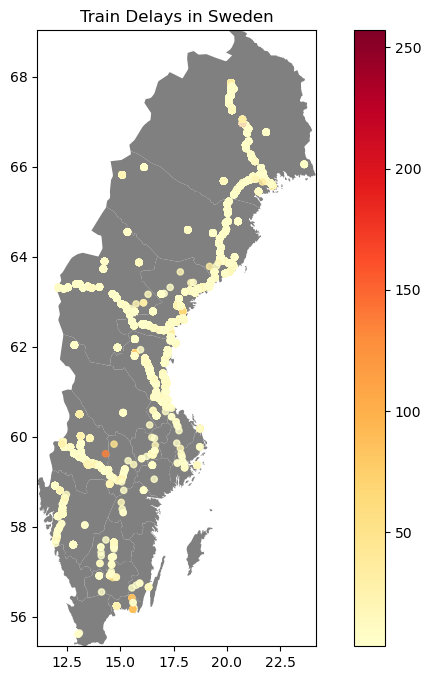

In [19]:
#4. Data visualisation – Plot the data spatially using the ‘geopandas’ library.
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, geometry="point")
url = "C:/Programming/IAI-eMaintenance-Assignment-2/ne_10m_admin_1_states_provinces.zip"
world = gpd.read_file(url)
sweden = world[world["admin"] == "Sweden"]

gdf = gdf.set_crs('EPSG:4326', allow_override=True)

fig, ax = plt.subplots(figsize=(10, 8))
sweden.plot(ax=ax, color="grey")

gdf.plot(ax=ax, column="registered delay", cmap="YlOrRd", markersize=20, legend=True, alpha=0.8)
ax.set_xlim([sweden.bounds.minx.min(), sweden.bounds.maxx.max()])
ax.set_ylim([sweden.bounds.miny.min(), sweden.bounds.maxy.max()])
plt.title("Train Delays in Sweden")
plt.show()

Above image show all train delays plotted out on their correct location in sweden combined with a heatmap to show where most delays occur.

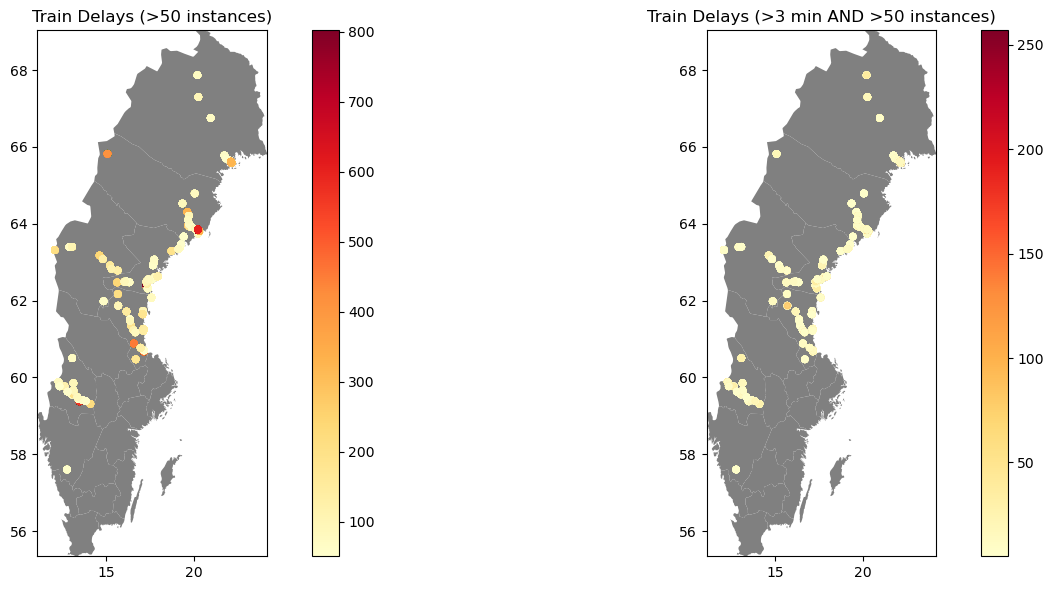

In [20]:
#new gdf with only over 50 counted delays
gdf_filter = gdf[gdf["PlaceDelayCount"] > 50]

#plot of train delays that are above 3min (not punctual)
gdf_not_punctual = gdf_filter[gdf_filter["Punctual"] == 0]

# two subplots
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))  # Two plots side by side

#1 subplot
sweden.plot(ax=axes[0], color="grey")
gdf_filter.plot(ax=axes[0], 
                  column="PlaceDelayCount", 
                  cmap="YlOrRd", 
                  markersize=20, 
                  legend=True, 
                  alpha=0.8)
axes[0].set_xlim([sweden.bounds.minx.min(), sweden.bounds.maxx.max()])
axes[0].set_ylim([sweden.bounds.miny.min(), sweden.bounds.maxy.max()])
axes[0].set_title("Train Delays (>50 instances)")

#2 subplot
sweden.plot(ax=axes[1], color="grey")
gdf_not_punctual.plot(ax=axes[1], 
                      column="registered delay", 
                      cmap="YlOrRd", 
                      markersize=20, 
                      legend=True, 
                      alpha=0.8)
axes[1].set_xlim([sweden.bounds.minx.min(), sweden.bounds.maxx.max()])
axes[1].set_ylim([sweden.bounds.miny.min(), sweden.bounds.maxy.max()])
axes[1].set_title("Train Delays (>3 min AND >50 instances)")

plt.tight_layout()
plt.show()

Above image show two more filtered maps of sweden, where the left one only show locations that had more than 50 train delays and right image show locations with more than 50 train delays and only those that are above 3min. Some places show darker red in the heatmap and need to be inspected.

C:\Users\adam-\AppData\Local\Temp\ipykernel_14132\2052898264.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


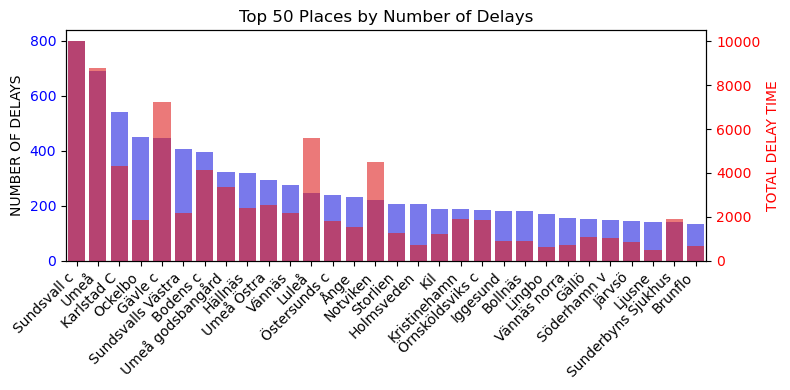

In [55]:
df_top_30_places = df.groupby("Place").agg(
    DelayCount=("registered delay", "count"),
    TotalDelayTime=("registered delay", "sum")
)

df_top_30_places = df_top_30_places.sort_values(by=["DelayCount", "TotalDelayTime"], ascending=False).head(30)

# fst axis
fig, ax1 = plt.subplots(figsize=(8, 4))
sb.barplot(x="Place", y="DelayCount", data=df_top_30_places, ax=ax1, color="blue", alpha=0.6)
ax1.set_xlabel("")
ax1.set_ylabel("NUMBER OF DELAYS")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

# snd axis
ax2 = ax1.twinx()
sb.barplot(x=df_top_30_places.index, y="TotalDelayTime", data=df_top_30_places, ax=ax2, color="red", alpha=0.6)
ax2.set_ylabel("TOTAL DELAY TIME", color="red")
ax2.tick_params(axis='y', labelcolor="red")


plt.title("Top 50 Places by Number of Delays")
plt.tight_layout()

plt.show()

Above image is a barplot that aims to futher show what places are suffering from the most number of delays and delay time. From this image we can see that Sundsvall c and Umeå both got the highest number of delays and time.

C:\Users\adam-\AppData\Local\Temp\ipykernel_14132\1011452512.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


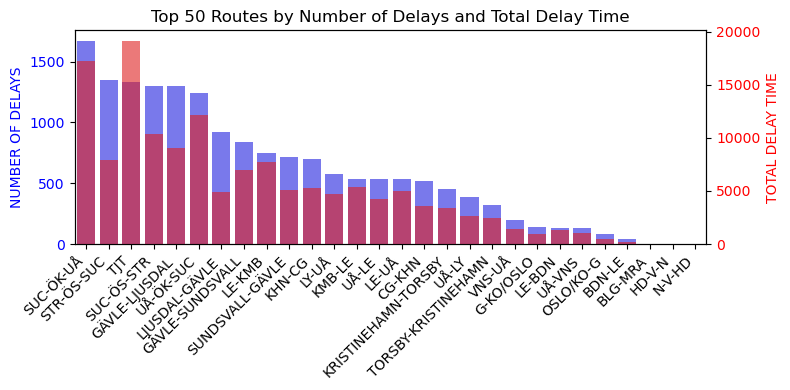

In [ ]:
#created new df because I didnt want totaldelaytime as a column in original
train_delay_top_50 = df.groupby("Route").agg(
    DelayCount=("registered delay", "count"),
    TotalDelayTime=("registered delay", "sum")
)

#sorting of the barplot
train_delay_top_50 = train_delay_top_50.reset_index()
train_delay_top_50 = train_delay_top_50.sort_values(by=["DelayCount", "TotalDelayTime"], ascending=False).head(50)
route_order = train_delay_top_50["Route"]

# fst axis
fig, ax1 = plt.subplots(figsize=(8, 4))
sb.barplot(x="Route", y="DelayCount", data=train_delay_top_50, ax=ax1, color="blue", alpha=0.6,order=route_order)
ax1.set_xlabel("")
ax1.set_ylabel("NUMBER OF DELAYS", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

# snd axis
ax2 = ax1.twinx()
sb.barplot(x="Route", y="TotalDelayTime", data=train_delay_top_50, ax=ax2, color="red", alpha=0.6)
ax2.set_ylabel("TOTAL DELAY TIME", color="red")
ax2.tick_params(axis='y', labelcolor="red")


plt.title("Top 50 Routes by Number of Delays and Total Delay Time")
plt.tight_layout()

plt.show()

C:\Users\adam-\AppData\Local\Temp\ipykernel_14132\2330349850.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")


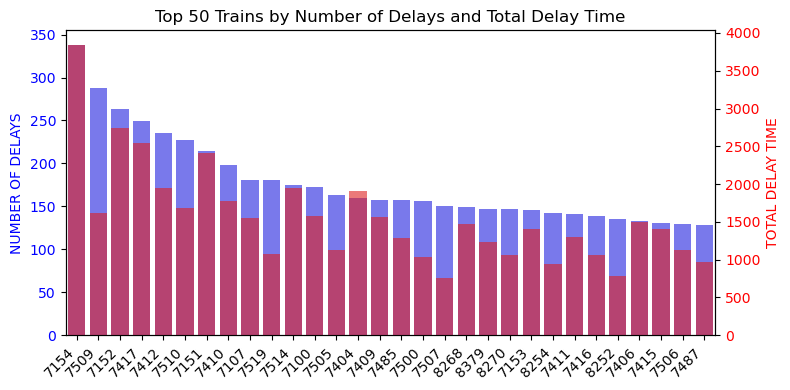

In [ ]:
#created new df because I didnt want totaldelaytime as a column in original
top_50_trains = df.groupby("Tågnr").agg(
    DelayCount=("registered delay", "count"),
    TotalDelayTime=("registered delay", "sum")
)

#sorting of the barplot
top_50_trains = top_50_trains.reset_index()
top_50_trains = top_50_trains.sort_values(by=["DelayCount", "TotalDelayTime"], ascending=False).head(30)
train_order = top_50_trains["Tågnr"]

# fst axis
fig, ax1 = plt.subplots(figsize=(8, 4))
sb.barplot(x="Tågnr", y="DelayCount", data=top_50_trains, ax=ax1, color="blue", alpha=0.6, order=train_order)
ax1.set_xlabel("")
ax1.set_ylabel("NUMBER OF DELAYS", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")

# snd axis
ax2 = ax1.twinx()
sb.barplot(x="Tågnr", y="TotalDelayTime", data=top_50_trains, ax=ax2, color="red", alpha=0.6)
ax2.set_ylabel("TOTAL DELAY TIME", color="red")
ax2.tick_params(axis='y', labelcolor="red")


plt.title("Top 50 Trains by Number of Delays and Total Delay Time")
plt.tight_layout()

plt.show()

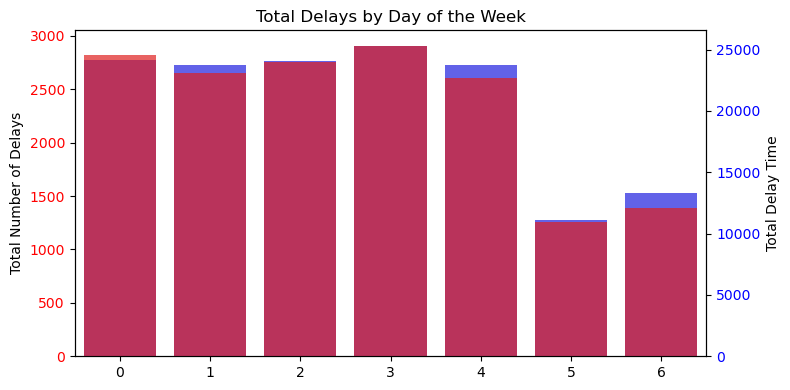

In [80]:
#created new df because I didnt want totaldelaytime as a column in original
# grped by day of the week and aggregates the total delays and counts
day_delay_summ = df.groupby('WeekDay').agg(
    DelayCount=('registered delay', 'count'),
    TotalDelayTime=('registered delay', 'sum')
).reset_index()


# fst axis
fig, ax1 = plt.subplots(figsize=(8, 4))

# DelayCount on the fst axis
sb.barplot(x='WeekDay', y='DelayCount', data=day_delay_summ, color="blue", alpha=0.7, ax=ax1)

ax1.set_xlabel("")
ax1.set_ylabel("Total Number of Delays")
ax1.set_title("Total Delays by Day of the Week")
ax1.tick_params(axis='y', labelcolor="red")

# snd axis
ax2 = ax1.twinx()

# TotalDelayTime on the snd axis
sb.barplot(x='WeekDay', y='TotalDelayTime', data=day_delay_summ, color="red", ax=ax2, alpha=0.7)

ax2.set_ylabel("Total Delay Time")
ax2.tick_params(axis='y', labelcolor="blue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [110]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, mean_squared_error, f1_score, precision_score
from sklearn.model_selection import train_test_split

features_train = ["WeekDay", "IsWeekend", "Route", "RouteDelayCount", "TrainDelayCount", "PlaceDelayCount"]
features_place = ["Route", "RouteDelayCount", "PlaceDelayCount", "WeekDay", "IsWeekend", "Punctual"]
features_route = ["Route", "RouteDelayCount", "TrainDelayCount", "WeekDay", "IsWeekend"]

Below is model for predicting if a TRAIN will be delayed

In [107]:
df["IsDelayed"] = (df["registered delay"] > 0).astype(int)
df["Route"] = LabelEncoder().fit_transform(df["Route"])

X = df[features_train]
y = df["Punctual"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6071856287425149
              precision    recall  f1-score   support

           0       0.58      0.59      0.59      1578
           1       0.63      0.62      0.62      1762

    accuracy                           0.61      3340
   macro avg       0.61      0.61      0.61      3340
weighted avg       0.61      0.61      0.61      3340



In [108]:
from sklearn.ensemble import RandomForestClassifier

# Initialize model with class_weight='balanced' in case of class imbalance
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Get the predicted probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the probability of the positive class (delayed)

# Show the predicted probabilities for the first 5 instances
print(y_pred_proba[:5])

from sklearn.metrics import roc_auc_score

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)


[0.89001235 0.82112279 0.39901585 0.8881184  0.37777407]
AUC Score: 0.6475549158477303


Below is model for predicting if a delay will happen in a PLACE

In [111]:
df["Place"] = LabelEncoder().fit_transform(df["Place"])

X = df[features_place]
y = df["Place"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8074850299401197
              precision    recall  f1-score   support

           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.77      0.87        13
           7       0.44      0.80      0.57         5
           8       1.00      1.00      1.00        13
           9       0.00      0.00      0.00         2
          11       0.83      0.83      0.83        12
          12       0.00      0.00      0.00         2
          13       0.97      0.92      0.94        36
          14       0.00      0.00      0.00         2
          15       0.20      0.08      0.12        12
          16       0.00      0.00      0.00         2
          17       0.83      0.71      0.77         7
          18       0.00      0.00      0.00         1
          19       0.98      0.98      0.98        60
          20       0.00      0.00      0.00         

c:\Users\adam-\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\adam-\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\adam-\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\adam-\anaconda3\Lib\site-packages\sklea

Below is model for predicting if a ROUTE will be punctual and within 5min

In [114]:
X = df[features_route]
y = df["Punctual"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.577245508982036
              precision    recall  f1-score   support

           0       0.55      0.59      0.57      1578
           1       0.61      0.57      0.59      1762

    accuracy                           0.58      3340
   macro avg       0.58      0.58      0.58      3340
weighted avg       0.58      0.58      0.58      3340

